In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
"""
============================================================================
[F, x, y_plot, y] = create_training_set(N, polynom_degree, noise_var, theta)
============================================================================
This function creates a training set, using N equidistant x points in the interval [0,2].
Parameters:
-N: number of training samples (integer)
-polynom_degree: degree of polynomial model (integer)
-noise_var: true variance of the noise (float/integer)
-theta: true thetas ((l+1)x1 vector, l=polynom_degree)
Return:
-F: x values of the training set with a last column containing ones (Nx(l+1) array, l=polynom_degree)
-x: N equidistant points in the interval [0,2] (Nx1 vector)
-y_plot: y values without noise (Nx1 vector)
-y: y values of the training set (with noise) (Nx1 vector)
"""
def create_training_set(N, polynom_degree, noise_var, theta):
    x = np.linspace(0, 2, N) # creates N equidistant x points in the interval [0,2]
    X = np.array(np.zeros(N)) # initialization of X array
    for i in range(1, polynom_degree + 1): # creates the X array for the given polynomial model
        X = np.column_stack((X, x**(i)))
    X = X[:,1:] # deletes the first column of X containing zeros
    F = np.column_stack((X, np.ones(N))) # adds a last column to X containing ones to create the F matrix

    noise = np.random.normal(0, np.sqrt(noise_var), N) # creates N noise samples derived from a Gaussian distribution
                                                       # with mean=0 and sd=sqrt(noise_var)
    y_plot = F @ theta # calculates the y's without noise
    y = F @ theta + noise # calculates the y's (with noise)
    return [F, x, y_plot, y]

"""
=======================================================================================
[F_test, test, true_test_y] = create_test_set(N_test, polynom_degree, noise_var, theta)
=======================================================================================
This function creates a test set, using N_test randomly selected x points in the interval [0,2].

Parameters:
-N_test: number of test samples (integer)
-polynom_degree: degree of polynomial model (integer)
-noise_var: true variance of the noise (float/integer)
-theta: true thetas ((l+1)x1 vector, l=polynom_degree)
Return:
-F_test: x values of the test set with a last column containing ones ((N_test)x(l+1) array, l=polynom_degree)
-test: N_test random points in the interval [0,2] ((N_test)x1 vector)
-true_test_y: y values of the test set ((N_test)x1 vector)
"""
def create_test_set(N_test, polynom_degree, noise_var, theta):
    test = np.random.uniform(low=0, high=2, size=(N_test,)) # selects randomly 20 points in the interval [0,2]
    X_test = np.array(np.zeros(N_test)) # initialization of X_test array
    for i in range(1, polynom_degree + 1): # creates the X_test array for the given polynomial model
        X_test = np.column_stack((X_test, test**(i)))
    X_test = X_test[:,1:] # deletes the first column of X_test containing zeros
    F_test = np.column_stack((X_test, np.ones(N_test))) # adds a last column to X containing ones to create 
                                                        # the F matrix
    noise = np.random.normal(0, np.sqrt(noise_var), N_test) # creates N_test noise samples derived from a Gaussian
                                                            # distribution with mean=0 and sd=sqrt(noise_var)
    true_test_y = F_test @ theta + noise # calculates the test set y's
    return [F_test, test, true_test_y]

"""
======================================================================
[theta_var_EM, noise_var_EM, a_EM, b_EM] = EM_algorithm(F, y, a, b, e)
======================================================================
This function estimates the noise variance and theta variance using the Expectation-Maximization algorithm.

Parameters:
-F: x values of the training set with a last column containing ones (Nx(l+1) array)
-y: y values of the training set (Nx1 vector)
-a: initialization value of a [a = 1/(theta variance)] (integer/float)
-b: initialization value of b [a = 1/(noise variance)] (integer/float)
-e: threshold for algorithm termination (integer/float)
Return:
-theta_var_EM: theta variance as estimated by the EM algorithm (float)
-noise_var_EM: noise variance as estimated by the EM algorithm (float)
-a: a value as estimated by the EM algorithm [a = 1/(theta_var_EM)] (float)
-b: a value as estimated by the EM algorithm [b = 1/(noise_var_EM)] (float)
"""
def EM_algorithm(F, y, a, b, e):
    K = len(F.shape) # dimensionality of the training set
    ctrl = True # initialization of while-condition
    while ctrl == True:
        # -Expectation step:
        theta_covar = np.linalg.inv(a * np.identity(len(F[0])) + b * F.T @ F) # calculates the theta covariance matrix 
        theta_MAP = b * theta_covar @ F.T @ y # calculates the theta estimates
        A = np.inner(theta_MAP, theta_MAP) + np.trace(theta_covar)
        temp = y - F @ theta_MAP
        B = np.inner(temp, temp) + np.trace(F @ theta_covar @ F.T)
        # -Maximization step:
        a_1 = K/A # calculates the new a
        b_1 = N/B # calculates the new b
        # -Update of while-criterion (ctrl), a and b:
        dif_a = abs(a_1 - a) # calculates the difference between a(j+1) and a(j)
        dif_b = abs(b_1 - b) # calculates the difference between b(j+1) and b(j)
        if dif_a < e and dif_b < e:
            ctrl = False # sets ctrl equal to False to exit the while-loop
        a = copy.deepcopy(a_1) # updates a
        b = copy.deepcopy(b_1) # updates b 
    a_EM = a
    b_EM = b
    theta_var_EM = a_EM**(-1)
    noise_var_EM = b_EM**(-1)
    return [theta_var_EM, noise_var_EM, a_EM, b_EM]

"""
===================================================================================================
[theta_MAP, theta_covar, bayes_pred_y, var_y] = bayes_inference(noise_var, theta_var, F, y, F_pred)
===================================================================================================
This function performs Bayesian Inference and estimates the y's and their variances for a data set (F_pred),
given the training set (F, y).

Parameters:
-noise_var: the true or the estimated noise variance (float/integer)
-theta_var: the true or the estimated theta variance (float/integer)
-F: x values of the training set with a last column containing ones (Nx(l+1) array)
-y: y values of the training set (Nx1 vector)
-F_pred: F matrix of samples, of which the y's we want to estimate ((N_pred)x(l+1) array)
Return:
-theta_MAP: MAP theta estimate ((l+1)x1 vector)
-theta_covar: theta_MAP covariance matrix estimate ((l+1)x(l+1) vector)
-bayes_pred_y: y estimates for the test set, using the theta_MAP estimate ((N_test)x1 vector)
-var_y: y variance estimate of Bayes Inference ((N_test)x1 vector)
"""
def bayes_inference(noise_var, theta_var, F, y, F_pred):
    theta_covar = np.linalg.inv(theta_var**(-1) * np.identity(len(F[0])) + noise_var**(-1) * F.T @ F) # calculates 
                                                                                         # theta covariance matrix
    theta_MAP = noise_var**(-1) * theta_covar @ F.T @ y # calculates the theta_MAP estimate
    bayes_pred_y = F_pred @ theta_MAP # calculates the y estimates for the F_pred using theta_MAP
    var_y = np.array([0]) # initialization of var_y array
    # Calculates the variance of all the y estimates
    for i in range(len(F_pred)):
        error = noise_var + noise_var * theta_var * F_pred[i,:].T @ np.linalg.inv(noise_var*np.identity(len(F[0])) \
                + theta_var* F.T @ F) @ F_pred[i,:]
        var_y = np.row_stack((var_y, error)) 
    var_y = var_y[1:,:] # vector containing the variance of every y estimate
    return [theta_MAP, theta_covar, bayes_pred_y, var_y]



1a) Noise variance as estimated by the EM algorithm:  0.05149146005217966
1b) True noise variance:  0.05
 2) Theta variance as estimated by the EM algorithm:  1.7895736864708296


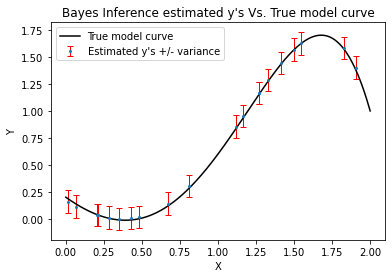

In [3]:
# i) Create a training set of 500 samples, using the true thetas, the true polynomial model 
#    (5th degree polynomial) and noise variance equal to 0.05:
N = 500 # number of training samples
polynom_degree = 5 # degree of polynomial model
noise_var = 0.05 # true variance of the noise
theta = np.array([-1, 0.9, 0.7, 0, -0.2, 0.2]) # true thetas
[F, x, y_plot, y] = create_training_set(N, polynom_degree, noise_var, theta) # creates the training set


# ii) Run the Expectation-Maximization algorithm to estimate the theta variance and the noise variance:
a = 1 # initialization of a
b = 1 # initialization of b
e = 0.0001 # threshold for EM_algorithm termination
[theta_var_EM, noise_var_EM, a_EM, b_EM] = EM_algorithm(F, y, a, b, e) # calculates the estimations of 
                                                                       # noise variance and theta variance
print('1a) Noise variance as estimated by the EM algorithm: ', noise_var_EM)
print('1b) True noise variance: ', noise_var)
print(' 2) Theta variance as estimated by the EM algorithm: ', theta_var_EM)


# iii) Create a test set of 20 samples, using the true thetas, the true polynomial model (5th degree polynomial)
#      and noise variance equal to 0.05:
N_test = 20 
[F_test, test, true_test_y] = create_test_set(N_test, polynom_degree, noise_var, theta)


# iv) Estimate the y's of the test set and their errors using Bayes Inference:
[theta_MAP, theta_covar, bayes_test_y, var_y] = bayes_inference(noise_var_EM, theta_var_EM, F, y, F_test)


# v) Plot the y's and their errors, along with the true model curve:
plt.errorbar(test, bayes_test_y, yerr = var_y[:,0]*2, linestyle='None', marker='.',  markersize=4, \
             ecolor='r',elinewidth=1,capsize=3, label="Estimated y's +/- variance") # plots the y's +/- variance
plt.plot(x,y_plot, 'k-', label="True model curve") # plots the true model curve
plt.legend(loc="upper left")
plt.title('Bayes Inference estimated y\'s Vs. True model curve') # adds title
plt.xlabel("X")
plt.ylabel("Y")
plt.show()